In [39]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import random
import itertools
from scipy import stats

# Defining some initial functions to generate random data. 
The gaussian process shall simulate the function based on a small data sample.

Plot shows the generation of random data with a sigmoid as latent function.

In [69]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x))) * 25

def sinusoidal(x):
    return np.sin(x) * 1

def gaussian(mean, var):
    def generate(x):
        return np.exp(-np.power(x - mean, 2.) / (2 * np.power(var, 2.)))
    return generate

def generate_data(num):
    X = np.random.normal(size=num)
    Y = np.random.normal(size=num)
    mu = np.array([0, 0])
    cov = np.array([[.5, .2],[.2, .5]])
    rv = stats.multivariate_normal(mu, cov)
    pos = np.dstack((X, Y))
    Z = rv.pdf(pos)
    return pd.DataFrame(np.dstack((X,Y,Z))[0], columns=["time_0", "time_1", "values"])




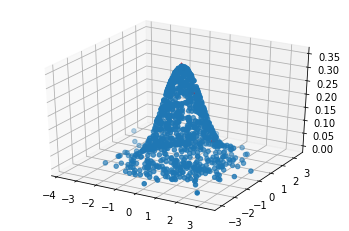

In [71]:
num = 1000

data_multiple_x = generate_data(num)
observed2 = data_multiple_x.sample(3).sort_values(by=["time_0","time_1"])
unobserved2 = data_multiple_x.sample(2)[["time_0","time_1"]]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_multiple_x["time_0"], data_multiple_x["time_1"], data_multiple_x["values"])
ax.scatter(observed2["time_0"], observed2["time_1"], observed2["values"], c="red", marker="^", s=50, depthshade=False)

# Prediction with 2-dimensional X and 1-dimensional Y

Methods implements kernel function and covariance construction according to equations below.

\begin{align}
    K &= \begin{bmatrix}
    k(x_1,x_1)&\cdots &k(x_n,x_1) \\
    \vdots & \ddots & \vdots\\
    k(x_1,x_n)&\cdots &k(x_n,x_n)
    \end{bmatrix} & K_* &= [k(x_*,x_1), \cdots, k(x_*,x_n)]\\
\end{align}

In [72]:
def vectorized_rbf_kernel(a,b, h_sigma = 1):
    # print(a,b)
    a_squared = np.square(np.linalg.norm(a))
    b_squared = np.square(np.linalg.norm(b))
    inner_product = (2 * (np.dot(a, b)))
    squared_diff = a_squared + b_squared - inner_product
    denominator = 2*np.square(h_sigma)
    # print(np.exp(-1*squared_diff/denominator))
    return np.exp(-1*squared_diff/denominator)

def create_covariance_matrix(a,b):
    shape = [len(a), len(b)]
    # print(shape) 
    all_covariances = [vectorized_rbf_kernel(x,y) for x,y in itertools.product(a,b)]
    # print(all_covariances)
    container = np.array(all_covariances).reshape(shape)
    return container

def process_cov_matrices(observed_X, unobserved_X):
    K = create_covariance_matrix(observed_X, observed_X)
    numerical_stabilizer = 1e-5*np.eye(len(K))
    K_stable = K + numerical_stabilizer
    K_star = create_covariance_matrix(unobserved_X, observed_X)
    K_star_star = create_covariance_matrix(unobserved_X, unobserved_X)
    return K_stable, K_star, K_star_star

### Methods to apply the prediction based on the covariance matrices $K, K_*, K_{**}$


\begin{align}
    y_{*} =& K_{*}K^{-1}Y \\
    \sigma_{*}^{2} =& K_{**} - K_* K^{-1} K_*^T
\end{align}

In [73]:
def process_predictions(K, K_star, K_star_star, Y):
    y_star = np.dot(K_star, np.linalg.inv(K)).dot(Y)
    sigma_star = K_star_star - np.dot(K_star, np.linalg.inv(K)).dot(K_star.T)
    return y_star, sigma_star

### Visualizatiuon showing observations in red and predictions and confidence itervall in green

### Methods for visualisation and prediction according to predefined functions.
### Visualizatiuon showing observations in red and predictions in green

In [82]:
def visualize_3d(dataX, dataY, dataZ, observedX, observedY, observedZ, predictX, predictY, prediction, uncertainty):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dataX[::10], dataY[::10], dataZ[::10])
    ax.scatter(observedX, observedY, observedZ, c="red")
    ax.scatter(predictX, predictY, prediction, c="green") 
    # ax.errorbar(predictX, predictY, prediction, yerr=uncertainty.diagonal()*50, c="green", capsize=1)
    return ax

def run_experiment_3d(sample_size, prediction_size, data_size=1000, dashes=False):
    data = generate_data(data_size)
    observed = data.sample(sample_size).sort_values(by=["time_0","time_1"])
    unobserved = data[["time_0","time_1"]].sample(prediction_size)#.sort_values()
    covXX, covXX_, covX_X_ = process_cov_matrices(observed[["time_0","time_1"]].values, unobserved.values)
    predictions, covariances = process_predictions(covXX, covXX_, covX_X_, observed["values"])
    visualize_3d(data["time_0"], data["time_1"], data["values"], observed["time_0"],observed["time_1"], observed["values"], unobserved["time_0"], unobserved["time_1"], predictions, covariances)

### Full run

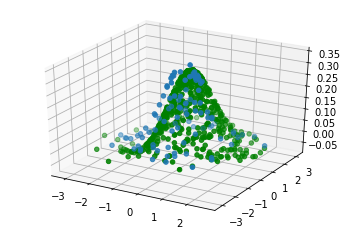

In [84]:
covXX, covXX_, covX_X_ = process_cov_matrices(observed2[["time_0","time_1"]].values, unobserved2.values)
predictions, covariances = process_predictions(covXX, covXX_, covX_X_, observed2["values"])
run_experiment_3d(3,500)